In [2]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import zipfile
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress



NSW valuer .DAT file information:
https://www.nsw.gov.au/sites/default/files/noindex/2024-05/Property_Sales_Information_Data_Files_User_guide.pdf

In [135]:

expected_dtypes = {
    'Record Type': 'string',
    'District Code': 'string',
    'Property Id': float,
    'Sale Counter': 'string',
    'Download Date/ Time': 'string',
    'Property Name': 'string',
    'Property Unit Number': 'string',
    'Property House Number': 'string',
    'Property Street Name': 'string',
    'Property Locality': 'string',
    'Property Post Code': float,
    'Area': float,
    'Area Type': 'string',
    'Contract Date': 'datetime64[ns]',
    'Settlement Date': 'datetime64[ns]',
    'Purchase Price': float,
    'Zoning': 'string',
    'Nature of Property': 'string',
    'Primary Purpose': 'string',
    'Strata Lot Number': 'string',
    'Component code': 'string',
    'Sale Code': 'string',
    '% Interest of Sale': 'string',
    'Dealing Number': 'string'
}



In [22]:
def download_nsw_valuer_sales_data(download_dir, mode='weekly'):
    """Download NSW valuer sales data to a local directory."""
    url = 'https://valuation.property.nsw.gov.au/embed/propertySalesInformation'

    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"download_nsw_valuer_sales_data: Error fetching URL {url}: {e}")
        return False

    soup = BeautifulSoup(response.content, 'html.parser')

    weekly_div = soup.find('div', class_='panel-body weekly')
    yearly_div = soup.find('div', class_='panel-body annual')

    if mode == 'weekly':
        if weekly_div:
            links = weekly_div.find_all('a', href=True)
        else:
            print("download_nsw_valuer_sales_data: No 'panel-body weekly' div found on the page.")
            return False
    elif mode == 'yearly':
        if yearly_div:
            links = yearly_div.find_all('a', href=True)
        else:
            print("download_nsw_valuer_sales_data: No 'panel-body annual' div found on the page.")
            return False
    else:
        print("download_nsw_valuer_sales_data: Invalid mode specified.")
        return False

    zip_links = [link['href'] for link in links if link['href'].endswith('.zip')]

    # Directory to save downloaded files
    os.makedirs(download_dir, exist_ok=True)

    # Download each .zip file
    for zip_link in zip_links:
        file_name = os.path.join(download_dir, os.path.basename(zip_link))
        print(f'Downloading {zip_link} to {file_name}')
        try:
            zip_response = requests.get(zip_link)
            zip_response.raise_for_status()
            with open(file_name, 'wb') as file:
                file.write(zip_response.content)
        except requests.RequestException as e:
            print(f"download_nsw_valuer_sales_data: Error downloading {zip_link}: {e}")
            return False
        except IOError as e:
            print(f"download_nsw_valuer_sales_data: Error writing to file {file_name}: {e}")
            return False

    return True

In [5]:
def extract_zip_files(input_dir: str, output_dir: str) -> dict:
    results = {}
    
    for file in os.listdir(input_dir):
        if file.endswith('.zip'):
            file_path = os.path.join(input_dir, file)
            try:
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(output_dir)
                results[file] = 'Success'
            except zipfile.BadZipFile as e:
                logging.error(f'extract_zip_files: Bad zip file - {file_path}: {e}')
                results[file] = 'Bad zip file'
            except Exception as e:
                logging.error(f'extract_zip_files: Error extracting {file_path}: {e}')
                results[file] = f'Error: {e}'
    
    return results

    

In [6]:
def process_dat_files_in_directory(directory_path):
    # Initialize lists to hold the extracted rows from all files
    all_sales_details = []
    all_additional_sales_details = []

    # Iterate over each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.DAT'):
            file_path = os.path.join(directory_path, filename)
            # print(file_path)
            
            # Open and read each file
            with open(file_path, 'r') as file:
                for line in file:
                    # Split the line by the delimiter ';'
                    columns = line.strip().split(';')
                    
                    # Check the first value and append the row to the appropriate list
                    if columns[0] == 'B':
                        all_sales_details.append(columns)
                    elif columns[0] == 'C':
                        all_additional_sales_details.append(columns)

    # Convert lists to DataFrames
    sales_df = pd.DataFrame(all_sales_details)
    additional_sales_df = pd.DataFrame(all_additional_sales_details)

    # Return both DataFrames as a tuple
    return sales_df, additional_sales_df

In [156]:
def clean_and_prepare_sales_data(sales, expected_dtypes):
    # sales = sales.replace('', np.nan)# 
    sales = sales.drop(sales.columns[-1], axis=1)
    column_headers = ['Record Type', 'District Code',  'Property Id' ,'Sale Counter' ,'Download Date/ Time','Property Name','Property Unit Number','Property House Number','Property Street Name','Property Locality','Property Post Code','Area','Area Type','Contract Date','Settlement Date','Purchase Price','Zoning','Nature of Property','Primary Purpose','Strata Lot Number','Component code', 'Sale Code','% Interest of Sale', 'Dealing Number']

    if len(sales.columns) == len(column_headers):
        sales.columns = column_headers
    else:
        print('Column headers do not match')
        exit()

    sales = sales.dropna(subset=['Area', 'Purchase Price']) 

    for column, dtype in expected_dtypes.items():
            if column in sales.columns:
                if dtype == 'datetime64[ns]':
                    sales[column] = pd.to_datetime(sales[column], errors='coerce')
                else:
                    # Replace empty strings with NaN for integer conversion
                    sales[column] = sales[column].replace('', np.nan)
                    try:
                        sales[column] = sales[column].astype(dtype, errors='raise')
                    except ValueError as e:
                        print(f"Error converting column '{column}' to {dtype}: {e}")
            else:
                print(f"Column '{column}' not found in DataFrame.")

    # if  exclude_na_records:
    #     sales['Area'] = sales['Area'].dropna().astype(float)
    #     sales['Purchase Price'] = sales['Purchase Price'].dropna().astype(float)
    #     sales = sales.dropna(subset=['Property Post Code'])
    # sales['Property Post Code'] = sales['Property Post Code'].astype(int)

    sales = sales[sales['Area'] >= 50]
    sales['price_per_m2'] = round(sales['Purchase Price'] / sales['Area'])

    return sales

        



In [158]:
input_dir = '/Users/bryanodonovan/Documents/NSW_sales_data'
output_dir = '/Users/bryanodonovan/Documents/NSW_sales_data/extracted'
years = '/Users/bryanodonovan/Documents/NSW_sales_data/yearly/years'
yearly_dir = '/Users/bryanodonovan/Documents/NSW_sales_data/yearly'
weekly_dir = '/Users/bryanodonovan/Documents/NSW_sales_data/weekly'


download_nsw_valuer_sales_data(weekly_dir, mode='weekly')
download_nsw_valuer_sales_data(yearly_dir, mode='yearly')

extract_zip_files(yearly_dir, years)
extract_zip_files(years, output_dir)
extract_zip_files(weekly_dir,output_dir)




{'20240226.zip': 'Success',
 '20240805.zip': 'Success',
 '20240408.zip': 'Success',
 '20240422.zip': 'Success',
 '20240219.zip': 'Success',
 '20240812.zip': 'Success',
 '20240624.zip': 'Success',
 '20240318.zip': 'Success',
 '20240708.zip': 'Success',
 '20240325.zip': 'Success',
 '20240520.zip': 'Success',
 '20240722.zip': 'Success',
 '20240108.zip': 'Success',
 '20240527.zip': 'Success',
 '20240122.zip': 'Success',
 '20240311.zip': 'Success',
 '20240715.zip': 'Success',
 '20240701.zip': 'Success',
 '20240729.zip': 'Success',
 '20240304.zip': 'Success',
 '20240129.zip': 'Success',
 '20240115.zip': 'Success',
 '20240101.zip': 'Success',
 '20240506.zip': 'Success',
 '20240513.zip': 'Success',
 '20240212.zip': 'Success',
 '20240617.zip': 'Success',
 '20240603.zip': 'Success',
 '20240429.zip': 'Success',
 '20240415.zip': 'Success',
 '20240401.zip': 'Success',
 '20240205.zip': 'Success',
 '20240610.zip': 'Success'}

In [159]:
sales = process_dat_files_in_directory(output_dir)[0]
sales = clean_and_prepare_sales_data(sales, expected_dtypes)


In [160]:
sales.describe()

,Property Id,Property Post Code,Area,Purchase Price,price_per_m2
count,1.213193e+06,1.213188e+06,1.213200e+06,1.213200e+06,1.213200e+06
mean,2.589859e+06,2.381384e+03,7.557021e+02,1.273303e+06,3.663973e+03
std,1.472476e+06,2.467239e+02,1.182911e+03,8.387557e+06,2.177592e+04
min,1.000000e+01,2.000000e+03,5.000000e+01,1.000000e+02,0.000000e+00
25%,1.232412e+06,2.168000e+03,2.900000e+02,4.455000e+05,6.800000e+02
50%,2.667518e+06,2.322000e+03,5.628000e+02,7.000000e+05,1.450000e+03
75%,3.982474e+06,2.570000e+03,7.754000e+02,1.130000e+06,3.926000e+03
max,4.565474e+06,4.385000e+03,2.703300e+05,8.624414e+08,5.649211e+06


3844324	605 / 2 Pearl St, Erskineville NSW 2043	38/SP89915	75 M	15/03/2015	$725,00

In [161]:
residential_unit_sales = sales[(sales['Primary Purpose'] == 'RESIDENCE') & (sales['Property Unit Number'] != 'nan')]
residential_unit_sales = residential_unit_sales.set_index('Contract Date').sort_index(ascending=False)
erko = residential_unit_sales[residential_unit_sales['Property Post Code'] == 2043]

In [164]:

erko['price_per_m2'].resample('2Q').mean().round()



Contract Date
2013-12-31     7037.0
2014-06-30     8563.0
2014-12-31     8646.0
2015-06-30     9116.0
2015-12-31     9447.0
2016-06-30     9004.0
2016-12-31     9413.0
2017-06-30    10471.0
2017-12-31    10063.0
2018-06-30    10492.0
2018-12-31     9414.0
2019-06-30    10516.0
2019-12-31     9928.0
2020-06-30     9825.0
2020-12-31     9195.0
2021-06-30    10430.0
2021-12-31    10518.0
2022-06-30    10342.0
2022-12-31     9740.0
2023-06-30    10013.0
2023-12-31    10811.0
2024-06-30    10871.0
Freq: 2Q-DEC, Name: price_per_m2, dtype: float64

In [220]:
print(f'estimated value of 605 2 Pearl st based on previous sales price and average  appreciation per sqm since last sale = {round(10871.0/9116.0 *725000)}')



estimated value of 605 2 Pearl st based on previous sales price and average  appreciation per sqm since last sale = 864576


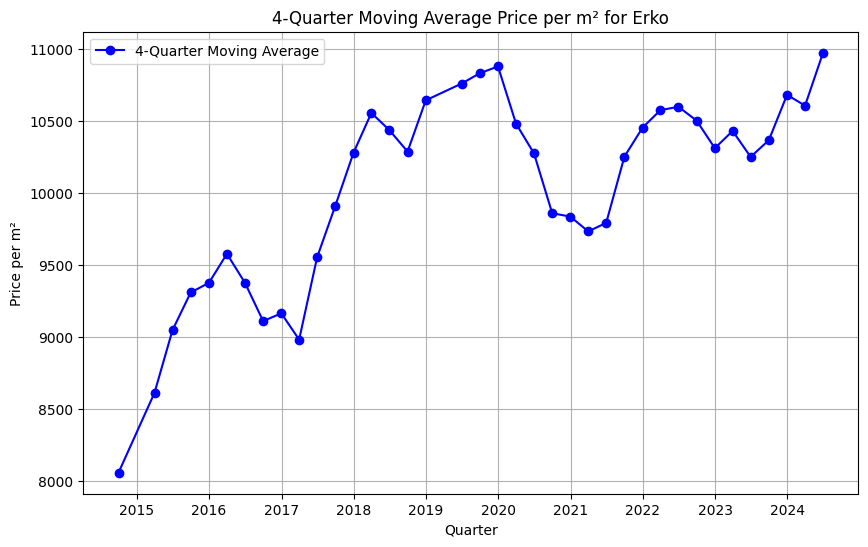

In [221]:

resampled_data = erko['price_per_m2'].resample('Q').mean().dropna().round()

# Calculate the 4-quarter moving average
moving_avg = resampled_data.rolling(window=4).mean()

# Plotting only the 4-quarter moving average
plt.figure(figsize=(10, 6))
plt.plot(moving_avg.index, moving_avg, marker='o', linestyle='-', label='4-Quarter Moving Average', color='blue')
plt.title('4-Quarter Moving Average Price per m² for Erko')
plt.xlabel('Quarter')
plt.ylabel('Price per m²')
plt.legend()
plt.grid(True)
plt.show()

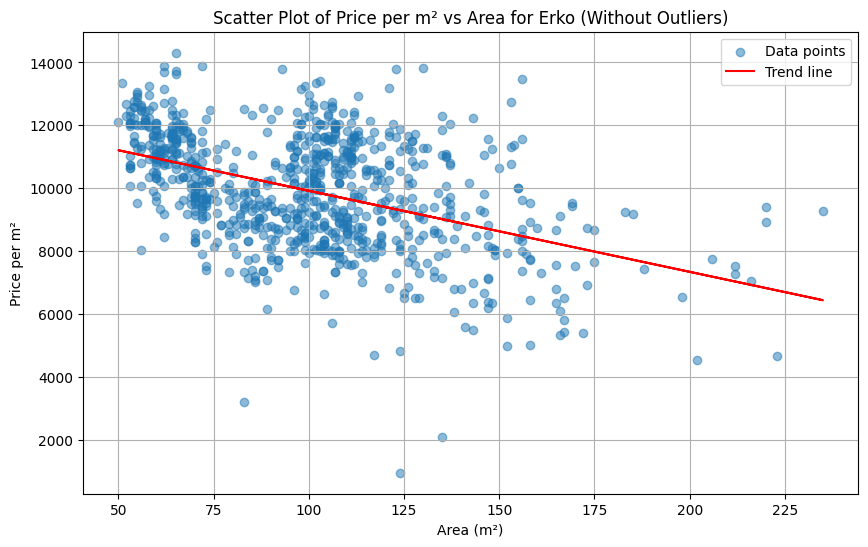

Slope: -25.746731501320426
Intercept: 12497.981051936971
R-squared: 0.20128120677665406
P-value: 4.601574139383846e-44


In [169]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = erko['Area'].quantile(0.10)
Q3 = erko['Area'].quantile(0.90)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_erko = erko[(erko['Area'] >= lower_bound) & (erko['Area'] <= upper_bound)]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_erko['Area'], filtered_erko['price_per_m2'], alpha=0.5, label='Data points')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(filtered_erko['Area'], filtered_erko['price_per_m2'])

# Calculate the trend line
trend_line = intercept + slope * filtered_erko['Area']

# Plot the trend line
plt.plot(filtered_erko['Area'], trend_line, 'r', label='Trend line')

# Plot customization
plt.title('Scatter Plot of Price per m² vs Area for Erko (Without Outliers)')
plt.xlabel('Area (m²)')
plt.ylabel('Price per m²')
plt.legend()
plt.grid(True)
plt.show()

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

In [241]:
bin_edges = [51, 71, 91, 111,121,131]
bin_labels = ['51-70', '71-90', '91-110','111-120','121-130']

# Create bins for the 'Area' column
erko['Area_bin'] = pd.cut(erko['Area'], bins=bin_edges, labels=bin_labels, right=False)
erko = erko.dropna(subset=['Area_bin'])
erko.groupby([pd.Grouper(freq='2Q'), 'Area_bin'])['price_per_m2'].mean().round()






Contract Date  Area_bin
2013-12-31     51-70           NaN
               71-90        7314.0
               91-110       7336.0
               111-120         NaN
               121-130         NaN
                            ...   
2024-06-30     51-70       12143.0
               71-90       10835.0
               91-110      10738.0
               111-120     11604.0
               121-130     11047.0
Name: price_per_m2, Length: 110, dtype: float64

In [242]:

print(f'expected price per m2 for a 75m2 erko unit based on 70 - 90 bin and  price appreciation per sq in that bin by last sales price: {round((10835.0/9796.0)*725000)}') #(62.222, 74.444]



expected price per m2 for a 75m2 erko unit based on 70 - 90 bin and  price appreciation per sq in that bin by last sales price: 801896


In [243]:
result = erko.groupby([pd.Grouper(freq='2Q'), 'Area_bin'])['price_per_m2'].agg([
    ('min_price_per_m2', lambda x: round(x.min())),
    ('mean_price_per_m2', lambda x: round(x.mean())),
    ('max_price_per_m2', lambda x: round(x.max()))
])
result



min_price_per_m2  mean_price_per_m2  max_price_per_m2
Contract Date Area_bin                                                       
2013-12-31    51-70                  NaN                NaN               NaN
              71-90               7093.0             7314.0            7534.0
              91-110              7336.0             7336.0            7336.0
              111-120                NaN                NaN               NaN
              121-130                NaN                NaN               NaN
...                                  ...                ...               ...
2024-06-30    51-70              11250.0            12143.0           12727.0
              71-90               9091.0            10835.0           12557.0
              91-110              7593.0            10738.0           13796.0
              111-120             9821.0            11604.0           12920.0
              121-130             9677.0            11047.0           11719.0

[110 rows x 3 columns]

In [244]:
min_mean_max = [9091.0, 10835.0, 12557.0]

for measure in min_mean_max:
    print(f'expected price per m2 for a 75m2 erko unit based on {measure} price per m2: {round(measure *75)}')


expected price per m2 for a 75m2 erko unit based on 9091.0 price per m2: 681825
expected price per m2 for a 75m2 erko unit based on 10835.0 price per m2: 812625
expected price per m2 for a 75m2 erko unit based on 12557.0 price per m2: 941775


In [175]:
spv = sales[(sales['Property Street Name'] == 'MITCHELL RD') & (sales['Property House Number'] == '177')].set_index('Contract Date').resample('2Q')['price_per_m2'].mean().ffill()
spv


Contract Date
2015-09-30    7833.000000
2016-03-31    7003.600000
2016-09-30    7880.000000
2017-03-31    8362.800000
2017-09-30    7455.666667
2018-03-31    7823.000000
2018-09-30    7949.600000
2019-03-31    7949.600000
2019-09-30    7949.600000
2020-03-31    9001.000000
2020-09-30    8855.000000
2021-03-31    8007.333333
2021-09-30    8007.333333
2022-03-31    9765.666667
2022-09-30    8615.000000
2023-03-31    9328.000000
2023-09-30    9359.400000
2024-03-31    9660.500000
Freq: 2Q-DEC, Name: price_per_m2, dtype: float64